In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from PIL import Image
from torchsummary import summary
import torch.nn as nn
from utils import fit_model_unet, show_sample, show_sample_output, plot_curves, unet_dice_loss
from unet import UNet

In [2]:
class OxfordPetSegmentationDataset(OxfordIIITPet):
    def __init__(self, root="./data", split='trainval', transform_img=None, transform_tar=None, download=True):
        super().__init__(root=root, split=split, target_types='segmentation', download=download)
        self.transform_img = transform_img
        self.transform_tar = transform_tar

    def __getitem__(self, index):
        image_path, label_path = self._images[index], self._segs[index]
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform_img is not None:
            image = self.transform_img(image)

        if self.transform_tar is not None:
            label = self.transform_tar(label)
            label_one = torch.nn.functional.one_hot(label.squeeze().type(torch.LongTensor), num_classes=3)
            label_one = label_one.permute(2, 0, 1)

        return image, label, label_one

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.Lambda(lambda x: (x - 1).squeeze().type(torch.LongTensor))
])

# Create datasets and dataloaders
batch_size = 32

trainset = OxfordPetSegmentationDataset(
    root='./data',
    split='trainval',
    transform_img=train_transform,
    transform_tar=target_transform,
    download=True
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = OxfordPetSegmentationDataset(
    root='./data',
    split='test',
    transform_img=train_transform,
    transform_tar=target_transform,
    download=True
)

testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 791918971/791918971 [00:07<00:00, 99709509.57it/s] 


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 108467090.39it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


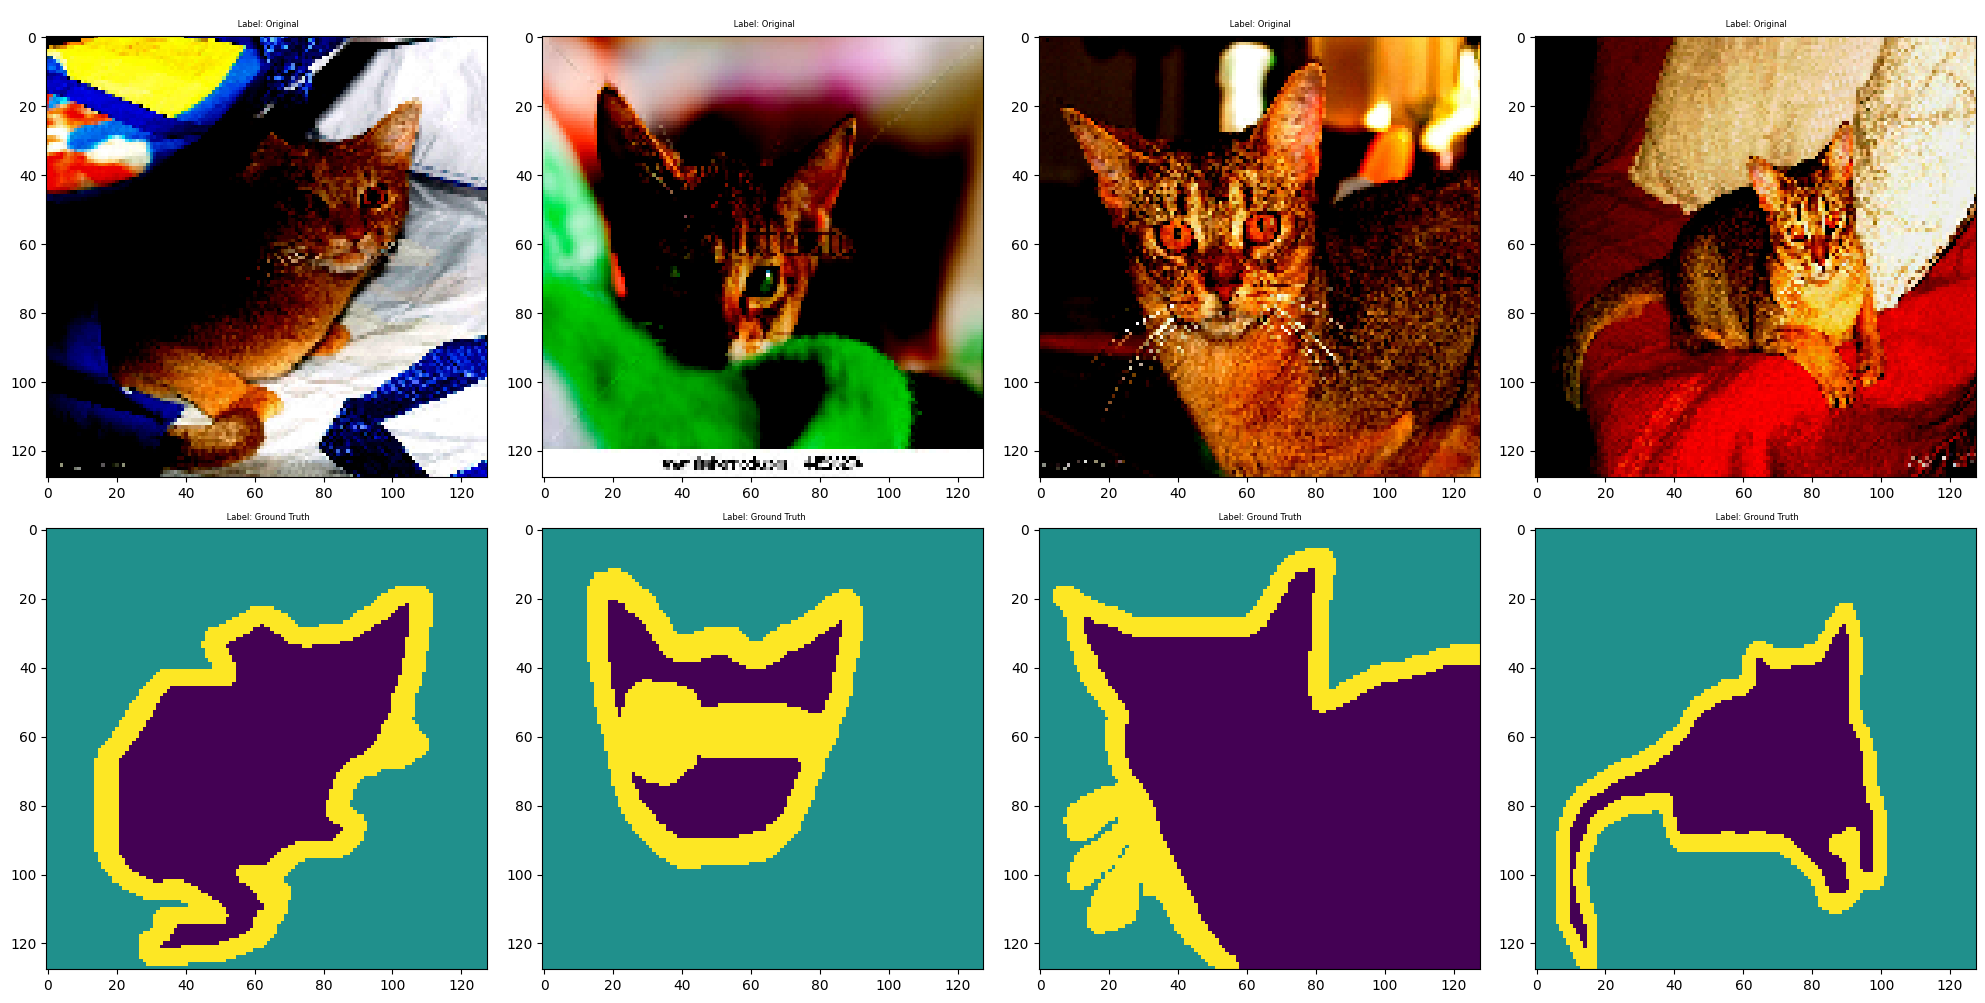

In [3]:
show_sample(trainset)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## MP+Tr+BCE

In [5]:
model = UNet(in_channels = 3, out_channels = 3).to(device)

In [6]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [7]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = nn.BCEWithLogitsLoss(),
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:36<00:00,  3.17it/s]

Training Loss: 60.3632572889328


Test set: Average loss=50.15588077902794

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:36<00:00,  3.19it/s]

Training Loss: 40.07536143064499


Test set: Average loss=38.95174199342728

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:36<00:00,  3.14it/s]

Training Loss: 32.18926155567169


Test set: Average loss=30.74666804075241

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.09it/s]

Training Loss: 29.145321488380432


Test set: Average loss=30.046919986605644

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.06it/s]

Training Loss: 27.04190292954445


Test set: Average loss=27.5900721848011

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: 25.21710856258869


Test set: Average loss=24.882273584604263

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: 23.753727003932


Test set: Average loss=23.697138369083405

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: 22.712631061673164


Test set: Average loss=23.403825134038925

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: 21.646747425198555


Test set: Average loss=23.520088031888008

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.03it/s]

Training Loss: 21.015395835042


Test set: Average loss=23.003749907016754

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.03it/s]

Training Loss: 20.204053595662117


Test set: Average loss=22.536896988749504

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: 19.157074630260468


Test set: Average loss=27.040552124381065

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: 18.404439315199852


Test set: Average loss=21.862955689430237

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: 17.737750947475433


Test set: Average loss=23.284170530736446

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: 17.3017116189003


Test set: Average loss=20.98933669924736


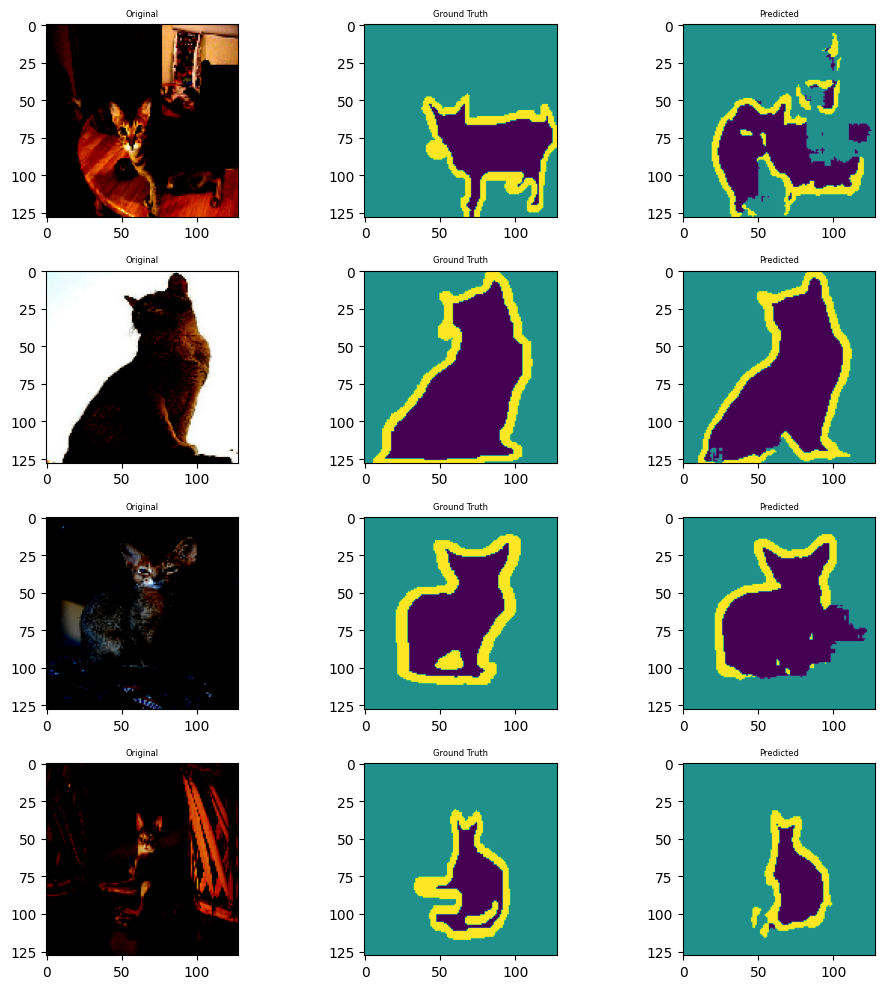

In [9]:
show_sample_output(model,testloader,device,image_no=4)

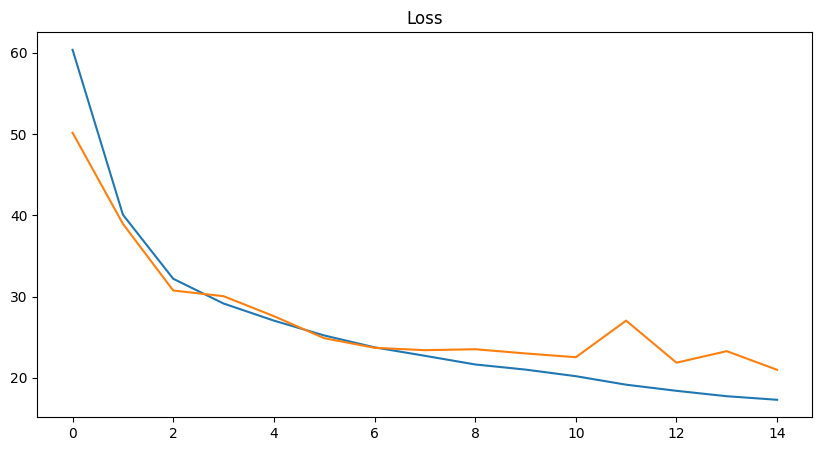

In [10]:
plot_curves(train_losses, test_losses)

## MP+Tr+Dice Loss

In [11]:
model = UNet(in_channels = 3, out_channels = 3).to(device)

In [12]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = unet_dice_loss,
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: -645.4281734824181


Test set: Average loss=-614.8337655067444

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: -3427.957187652588


Test set: Average loss=-4201.902862548828

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: -5032.401260375977


Test set: Average loss=-818.2374353408813

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.03it/s]

Training Loss: -4305.817535400391


Test set: Average loss=-1235.3026630878448

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: -1869.054326057434


Test set: Average loss=-3598.104528427124

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.03it/s]

Training Loss: -2177.446840286255


Test set: Average loss=-2430.9199018478394

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.04it/s]

Training Loss: -2378.460962295532


Test set: Average loss=-4625.98429775238

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: -2566.479516983032


Test set: Average loss=5714.252105712891

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: -2754.486280441284


Test set: Average loss=-7465.849848747253

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: -2963.5867958068848


Test set: Average loss=-2999.7245359420776

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.03it/s]

Training Loss: -3188.7146549224854


Test set: Average loss=-2399.849073410034

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: -3463.9424209594727


Test set: Average loss=-7162.621967315674

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  2.99it/s]

Training Loss: -3793.890853881836


Test set: Average loss=21762.065147399902

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.03it/s]

Training Loss: -4228.683155059814


Test set: Average loss=-3777.99848651886

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.02it/s]

Training Loss: -4777.271945953369


Test set: Average loss=-7813.068370819092


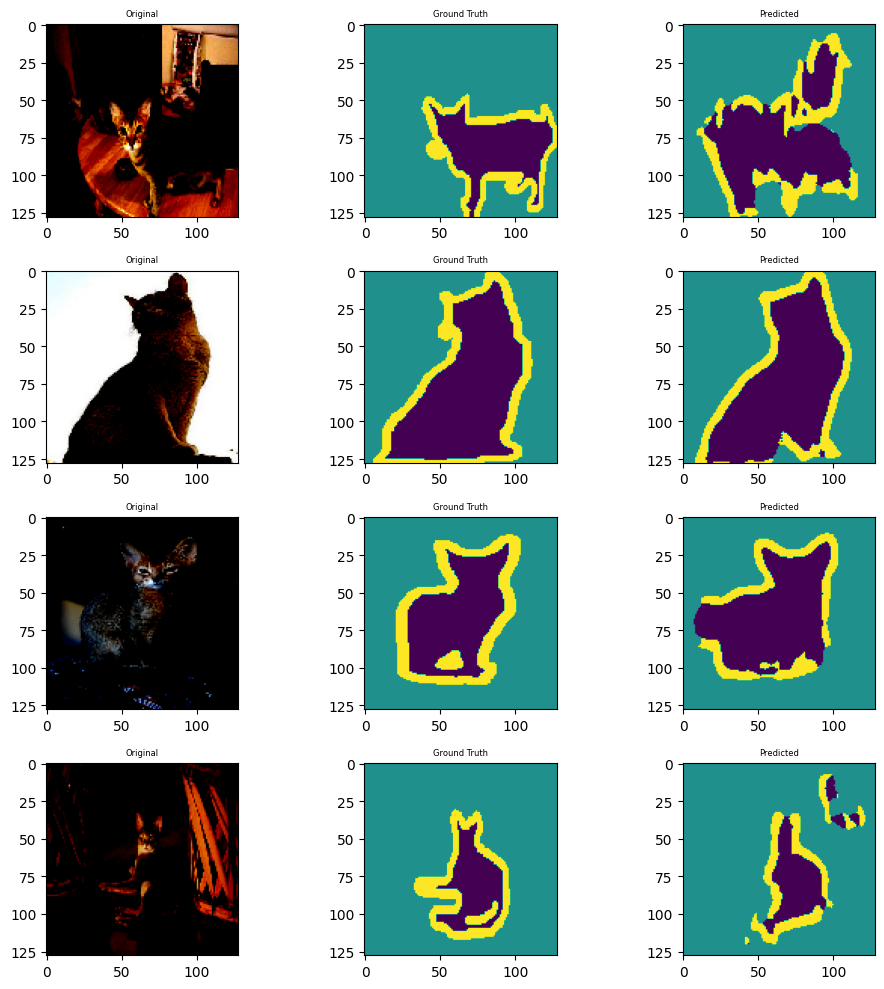

In [14]:
show_sample_output(model,testloader,device,image_no=4)

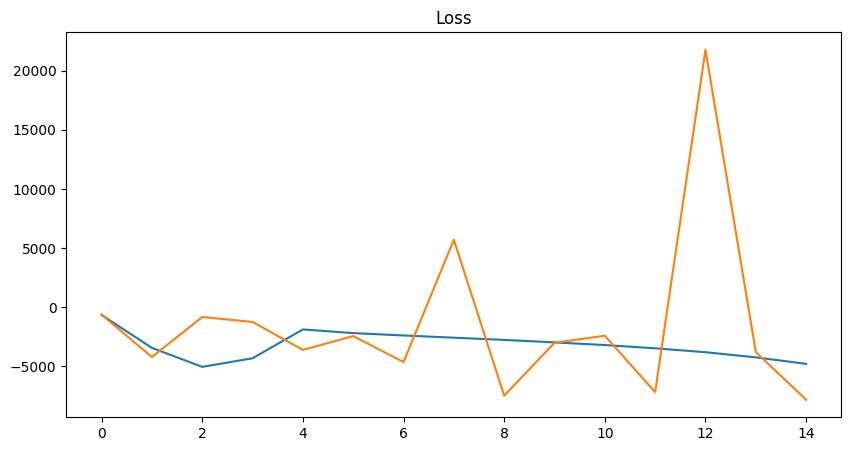

In [15]:
plot_curves(train_losses, test_losses)

## StrConv+Tr+BCE

In [16]:
model = UNet(in_channels = 3, out_channels = 3, pool='StrConv').to(device)

In [17]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [18]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = nn.BCEWithLogitsLoss(),
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.92it/s]

Training Loss: 59.28168797492981


Test set: Average loss=50.582764625549316

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: 40.59455433487892


Test set: Average loss=38.069352358579636

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: 34.50944301486015


Test set: Average loss=34.66575975716114

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 31.113258749246597


Test set: Average loss=32.17957930266857

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 29.244108632206917


Test set: Average loss=38.72736866772175

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: 26.771128863096237


Test set: Average loss=25.845978885889053

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 25.653208285570145


Test set: Average loss=24.762615725398064

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 24.352498099207878


Test set: Average loss=27.369234934449196

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: 24.057212486863136


Test set: Average loss=24.393328294157982

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: 22.85424692928791


Test set: Average loss=24.13390401005745

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.87it/s]

Training Loss: 21.790212243795395


Test set: Average loss=22.383690759539604

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 21.334162071347237


Test set: Average loss=22.104865238070488

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.87it/s]

Training Loss: 21.089536622166634


Test set: Average loss=23.094119757413864

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.87it/s]

Training Loss: 20.130963996052742


Test set: Average loss=22.403265446424484

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 19.857455044984818


Test set: Average loss=23.296960920095444


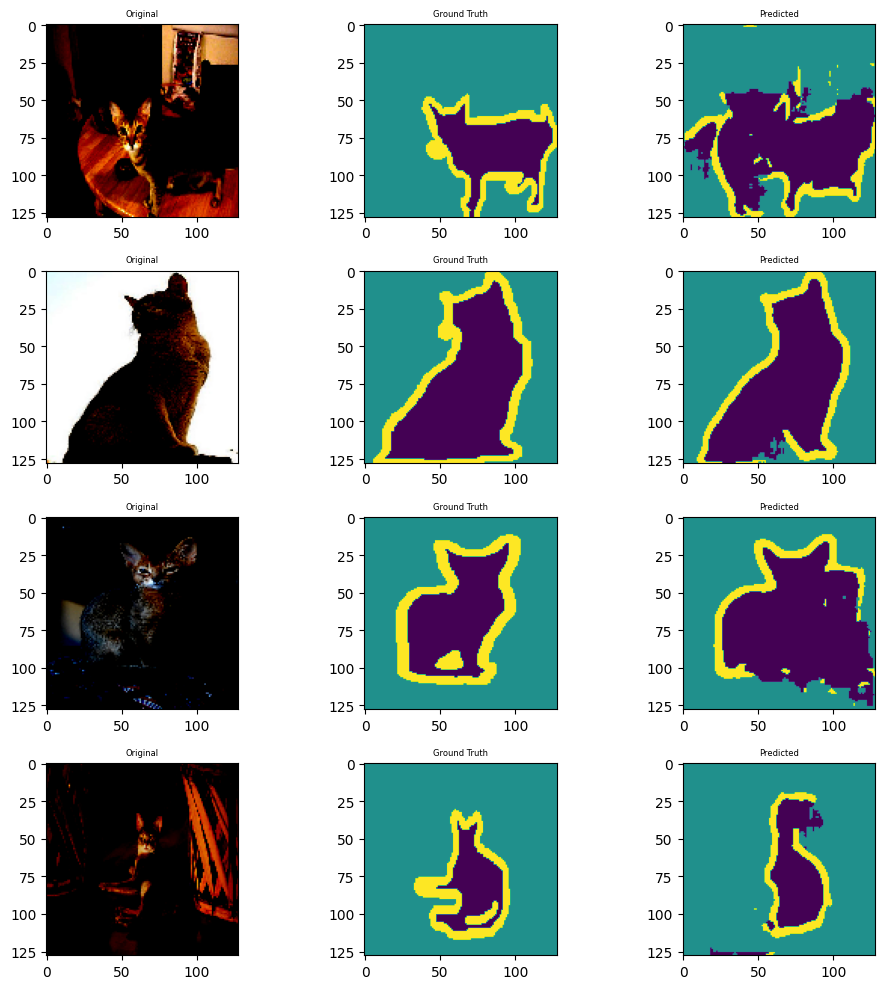

In [20]:
show_sample_output(model,testloader,device,image_no=4)

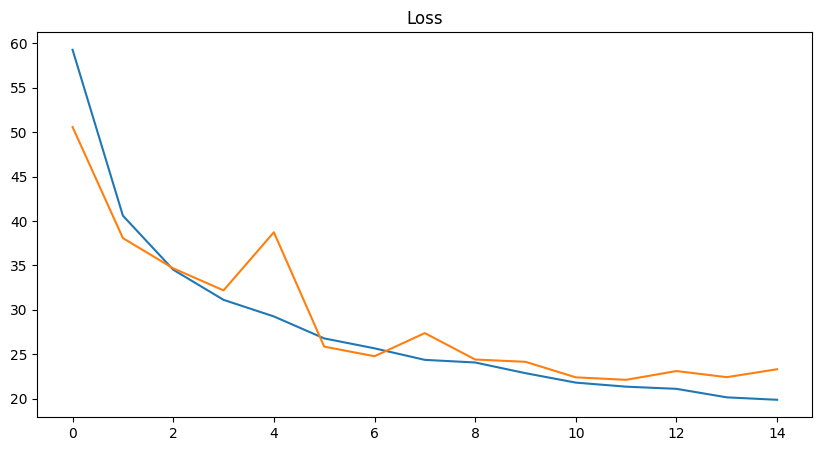

In [21]:
plot_curves(train_losses, test_losses)

## StrConv+Ups+Dice Loss

In [22]:
model = UNet(in_channels = 3, out_channels = 3, mode='upsample', pool='StrConv').to(device)

In [23]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [24]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = unet_dice_loss,
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.92it/s]

Training Loss: 871.6035865545273


Test set: Average loss=-5008.712908744812

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -3677.148900985718


Test set: Average loss=-5752.4093379974365

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -4280.913234710693


Test set: Average loss=-6044.047201156616

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -4902.819976806641


Test set: Average loss=-22185.57576751709

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -5744.233791351318


Test set: Average loss=-1844.3939657211304

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -7157.59037399292


Test set: Average loss=2834.12703704834

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -10825.211524963379


Test set: Average loss=197.9672393798828

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -27080.651670098305


Test set: Average loss=-2045.6594133377075

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -1840.8104906082153


Test set: Average loss=-2007.750244140625

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -2110.354875564575


Test set: Average loss=-2434.166980743408

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -2249.0174503326416


Test set: Average loss=-2234.6525592803955

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -2328.1331520080566


Test set: Average loss=-2058.5925550460815

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -2381.7360496520996


Test set: Average loss=-3043.4421920776367

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -2437.9344005584717


Test set: Average loss=-2725.218065261841

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -2470.595293045044


Test set: Average loss=-3164.9092235565186


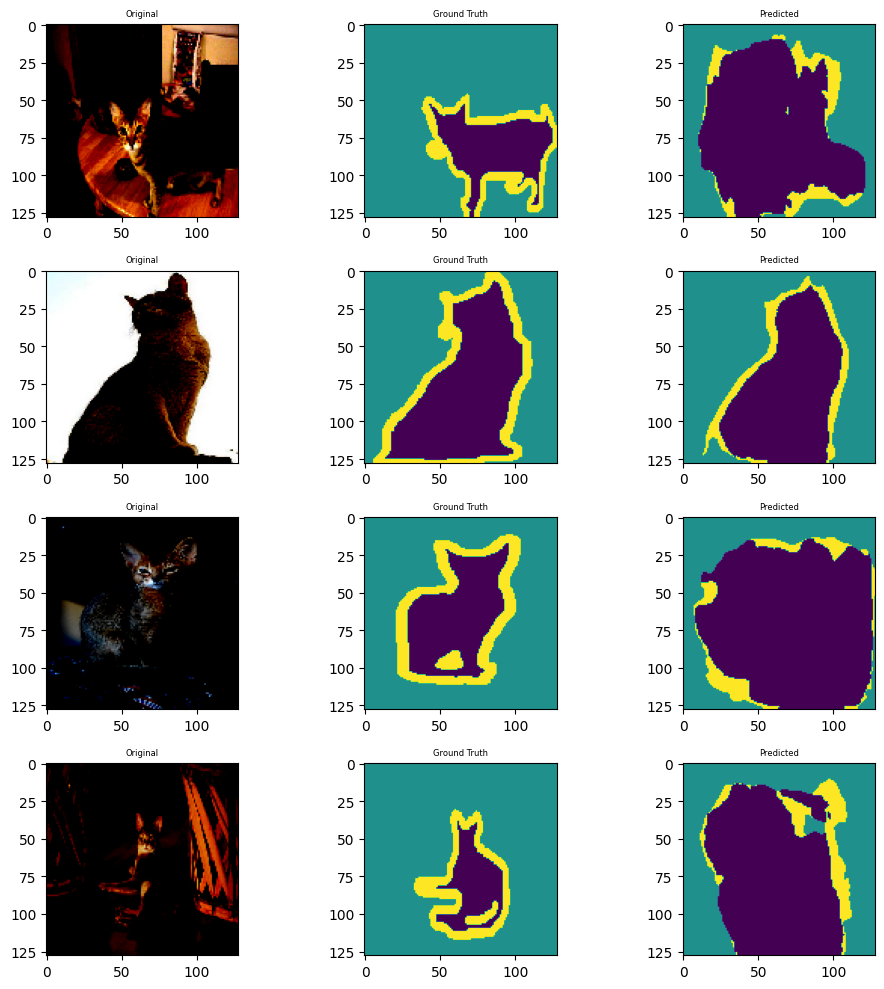

In [26]:
show_sample_output(model,testloader,device,image_no=4)

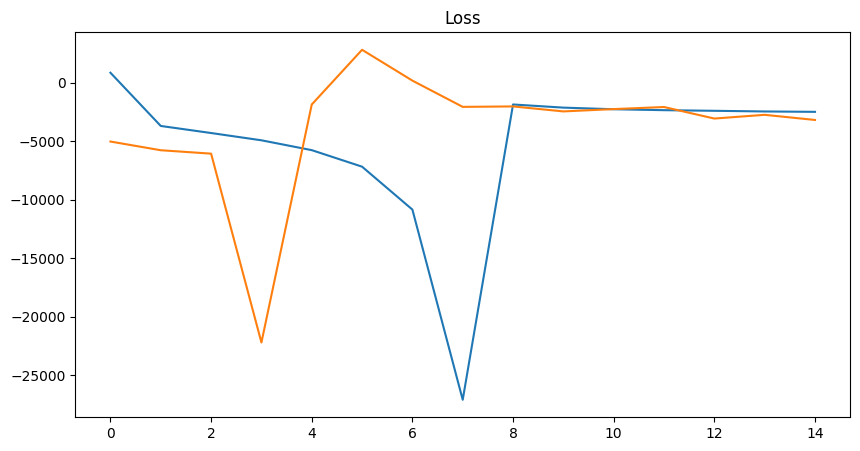

In [27]:
plot_curves(train_losses, test_losses)